# Notebook to reproduce figure 3

In [2]:
import os
import sys
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter

sys.path.append(os.path.join(sys.path[0], '../'))
from plot import plot_settings, plot_utils
from config import GEMINI_DIR

In [3]:
fig_dir = 'figure/fig3/' # move my figures here
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# Load results
#### simultaneously consider all GO terms regardless of sub-ontology

In [4]:
result_df = {'net': [], 'method': [], 'species': [], 'mean max f1': [], 'std dev max f1': [],
             'mean macro AUPRC': [], 'std dev macro AUPRC': [], 'mean micro AUPRC': [], 'std dev micro AUPRC': []}
for net in ['String', 'BioGrid', 'Combo']:
    for sp in ['mouse', 'human', 'yeast']:
        for method in ['gemini', 'mashup', 'bionic']:
            if method == 'bionic' and (sp != 'yeast' and net != 'String'):
                continue
            with open(GEMINI_DIR + 'results/{}/{}/{}.txt'.format(net, method.upper(), sp.lower()), 'r') as f:
                result_df['net'].append(net)
                result_df['method'].append(method)
                result_df['species'].append(sp)
                for line in f.readlines():
                    line = line.strip().split()
                    if 'F1:' in line:
                        result_df['mean max f1'].append(float(line[1]))
                        result_df['std dev max f1'].append(float(line[-1].split(')')[0]))
                    elif 'AUPRC:' in line:
                        result_df['mean micro AUPRC'].append(float(line[1]))
                        result_df['std dev micro AUPRC'].append(float(line[-1].split(')')[0]))
                    elif 'MAPRC:' in line:
                        result_df['mean macro AUPRC'].append(float(line[1]))
                        result_df['std dev macro AUPRC'].append(float(line[-1].split(')')[0]))

result_df = pd.DataFrame.from_dict(result_df)
result_df.head()

,net,method,species,mean max f1,std dev max f1,mean macro AUPRC,std dev macro AUPRC,mean micro AUPRC,std dev micro AUPRC
0,String,gemini,mouse,0.387978,0.004889,0.068514,0.007541,0.329902,0.006883
1,String,mashup,mouse,0.422421,0.002699,0.103537,0.003485,0.370148,0.005730
2,String,bionic,mouse,0.341043,0.002819,0.036643,0.001716,0.264850,0.004631
3,String,gemini,human,0.436842,0.003276,0.111265,0.005479,0.404699,0.005544
4,String,mashup,human,0.444900,0.005096,0.113355,0.004536,0.415370,0.007375


# Now, let's make the figure from the result df

In [5]:
subparts = ['a', 'b', 'c']
met_ordering = ['max f1', 'macro AUPRC', 'micro AUPRC']

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


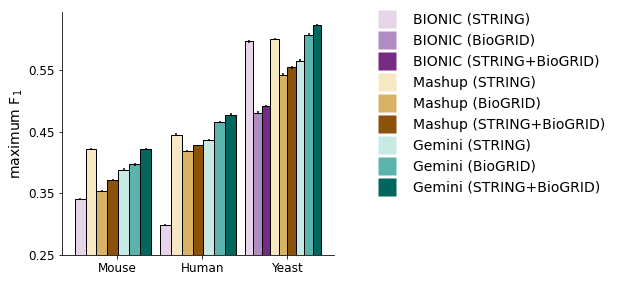

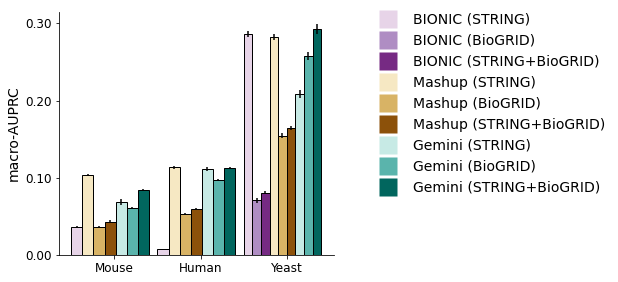

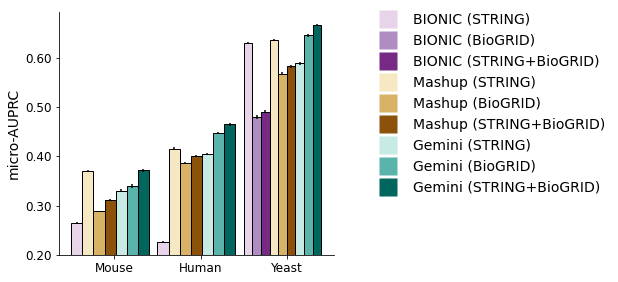

In [6]:
%matplotlib inline

for i in range(len(subparts)):
    met = met_ordering[i]
    
    ax = plot_settings.get_wider_axis(scale=2.3)
    model_ordering = plot_settings.get_model_ordering(['gemini', 'mashup', 'bionic'])
    net_ordering = plot_settings.get_network_ordering()
    
    
    means = []
    std_errs = []
    nested_colors = []
    nested_colornames = []
    for org in ['Mouse', 'Human', 'Yeast']:
        smeans, serrs, scols, scolnames = [], [], [], []
        dfOI = result_df[result_df['species'] == org.lower()]
        for mod in model_ordering:
            for net in net_ordering:
                if mod.lower() == 'bionic' and org != 'Yeast' and net != 'String':
                    continue
                smeans.append(
                    dfOI[(dfOI['method'] == mod.lower()) & (dfOI['net'] == net)]['mean {}'.format(met)].iloc[0])
                serrs.append(
                    dfOI[(dfOI['method'] == mod.lower()) & (dfOI['net'] == net)]['std dev {}'.format(met)].iloc[0] / np.sqrt(5.))
                scols.append(plot_settings.get_model_colors_by_network(mod, net))
                scolnames.append('{} ({})'.format(plot_settings.get_model_name_conventions(mod),
                                                   plot_settings.get_network_naming_convention(net)))
        means.append(smeans)
        std_errs.append(serrs)
        nested_colors.append(scols)
        nested_colornames.append(scolnames)

    min_val = 0.25 if met == 'max f1' else 0.2 if met == 'micro AUPRC' else 0
    plot_utils.grouped_barplot_variable_inputs(
        ax, means, ['Mouse', 'Human', 'Yeast'], xlabel='', ylabel=plot_settings.get_metric_name(met),
        nested_color_legend=None, nested_color=nested_colors, nested_errs=std_errs, 
        tickloc_top=False, min_val=min_val, rotangle=0)
    ytickstep = 0.1
    ymin, ymax = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(ymin, ymax+ytickstep/2., ytickstep))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    # identify all of the unique (color, label) combinations
    complete_col_list = [plot_settings.get_model_colors_by_network(mod, net) 
                         for mod in model_ordering for net in net_ordering]
    lp = lambda i: plt.plot([],[],color=complete_col_list[i], ms=18, mec="none",
                            label=nested_colornames[-1][i], ls="", marker='s')[0]
    handles = [lp(i) for i in range(len(model_ordering)*len(net_ordering))]
    
    plot_utils.format_legend(ax, handles, nested_colornames[-1])
    plot_utils.put_legend_outside_plot(ax)
    plot_utils.format_ax(ax)
    plt.tight_layout()
    plt.savefig(fig_dir + 'figure3_{}.pdf'.format(subparts[i]))